#  funci√≥n heur√≠stica adaptada al dominio VPN

Buscando un camino de 'q0' a 'q_pirata' usando A*...

### Resultados de A* ###
Camino encontrado: ['q0', 'q1', 'q4', 'q5', 'q_pirata']
Costo total del camino: 19
Nodos explorados: 7
Tiempo de ejecuci√≥n: 0.000079 segundos

üìä Tabla de costos de la ruta encontrada:

Desde    Hacia     Transici√≥n  Costo  Costo Acumulado
   q0       q1     auth_check      1                1
   q1       q4   geo_mismatch      5                6
   q4       q5 stream_attempt      5               11
   q5 q_pirata    session_end      8               19


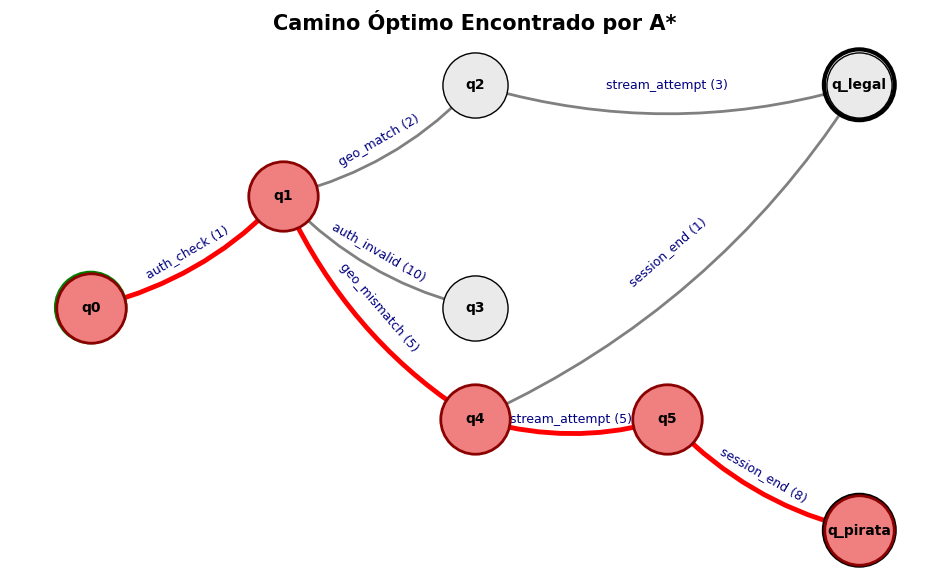

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import pandas as pd
import time

# ============================
# 1. Definir el grafo
# ============================
# Se han ajustado las aristas para reflejar la l√≥gica del modelo
# de detecci√≥n de VPN de forma m√°s precisa.
G = nx.DiGraph()
edges_with_cost = [
    ('q0', 'q1', 'auth_check', 1),
    ('q1', 'q2', 'geo_match', 2),
    ('q1', 'q3', 'auth_invalid', 10),
    ('q1', 'q4', 'geo_mismatch', 5),
    ('q2', 'q_legal', 'stream_attempt', 3),
    ('q4', 'q5', 'stream_attempt', 5),
    ('q4', 'q_legal', 'session_end', 1),
    ('q5', 'q_pirata', 'session_end', 8)
]

for u, v, label, costo in edges_with_cost:
    G.add_edge(u, v, label=label, costo=costo)

# Diccionario de equivalencias de estados para mayor claridad
state_meanings = {
    'q0': 'Inicio',
    'q1': 'Auth Check',
    'q2': 'Geo Match',
    'q3': 'Auth Invalid',
    'q4': 'Geo Mismatch',
    'q5': 'Stream Attempt',
    'q_legal': 'Usuario Legal',
    'q_pirata': 'Usuario Pirata'
}

# ============================
# 2. Definir la funci√≥n heur√≠stica
# ============================
# La heur√≠stica estima el costo restante hacia el estado 'q_pirata'.
# Se basa en la proximidad l√≥gica de cada estado al comportamiento pirata.
def heuristic(node):
    # Valores heur√≠sticos para cada nodo
    # Los valores se basan en la l√≥gica de riesgo del modelo
    h_values = {
        'q0': 8,       # Inicio, lejos del objetivo
        'q1': 7,       # Autenticaci√≥n pasada, a√∫n lejos
        'q2': 1,       # Coincidencia geogr√°fica, aleja del objetivo pirata
        'q3': 10,      # Autenticaci√≥n fallida, alto costo
        'q4': 5,       # Discrepancia geogr√°fica (VPN), camino directo a la clasificaci√≥n
        'q5': 3,       # Intento de streaming con VPN, muy cerca del objetivo
        'q_legal': 0,  # Estado objetivo no-pirata
        'q_pirata': 0   # Estado objetivo
    }
    return h_values.get(node, float('inf'))

# ============================
# 3. Implementaci√≥n del algoritmo A*
# ============================
def a_star_search(graph, start, goal, h_func):
    start_time = time.time()
    # Cola de prioridad: (f_cost, g_cost, node, path)
    pq = [(h_func(start), 0, start, [start])]
    # Diccionario para almacenar el costo m√°s bajo hasta el momento
    g_costs = {start: 0}
    explored_nodes = 0

    while pq:
        explored_nodes += 1
        # Extraer el nodo con el menor f_cost
        f_cost, g_cost, node, path = heapq.heappop(pq)

        if node == goal:
            end_time = time.time()
            return path, explored_nodes, g_cost, end_time - start_time

        # Explorar vecinos
        for neighbor in graph.neighbors(node):
            edge_cost = graph[node][neighbor]['costo']
            new_g_cost = g_cost + edge_cost

            # Si se encuentra un camino m√°s barato, se actualiza
            if neighbor not in g_costs or new_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = new_g_cost
                f_cost_new = new_g_cost + h_func(neighbor)
                heapq.heappush(pq, (f_cost_new, new_g_cost, neighbor, path + [neighbor]))

    return None, explored_nodes, None, time.time() - start_time

# ============================
# 4. Ejecuci√≥n del algoritmo y visualizaci√≥n
# ============================
start_node = 'q0'
goal_node = 'q_pirata'

print(f"Buscando un camino de '{start_node}' a '{goal_node}' usando A*...\n")

# Ejecutar A*
path_a_star, explored_a_star, cost_a_star, time_a_star = a_star_search(G, start_node, goal_node, heuristic)

# ============================
# 5. Presentaci√≥n de Resultados
# ============================
if path_a_star:
    print("### Resultados de A* ###")
    print(f"Camino encontrado: {path_a_star}")
    print(f"Costo total del camino: {cost_a_star}")
    print(f"Nodos explorados: {explored_a_star}")
    print(f"Tiempo de ejecuci√≥n: {time_a_star:.6f} segundos")

    # Crear tabla de costos del camino
    ruta_edges = list(zip(path_a_star, path_a_star[1:]))
    tabla_costos = []
    costo_acumulado = 0
    for u, v in ruta_edges:
        data = G[u][v]
        costo_acumulado += data["costo"]
        tabla_costos.append({
            "Desde": u,
            "Hacia": v,
            "Transici√≥n": data["label"],
            "Costo": data["costo"],
            "Costo Acumulado": costo_acumulado
        })

    df_costos = pd.DataFrame(tabla_costos)
    print("\nüìä Tabla de costos de la ruta encontrada:\n")
    print(df_costos.to_string(index=False))

    # Visualizaci√≥n de la ruta encontrada por A*
    pos = {
        'q0': (0, 0), 'q1': (2, 1), 'q2': (4, 2), 'q3': (4, 0),
        'q4': (4, -1), 'q5': (6, -1), 'q_legal': (8, 2), 'q_pirata': (8, -2)
    }

    plt.figure(figsize=(12, 7), facecolor="white")
    nx.draw_networkx_nodes(G, pos, node_size=2200, node_color='#EAEAEA', edgecolors='black')
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, arrowsize=20, width=2, connectionstyle="arc3,rad=0.15")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    edge_labels = {(u, v): f"{data['label']} ({data['costo']})" for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="navy")
    nx.draw_networkx_nodes(G, pos, nodelist=['q0'], node_size=2500, node_color="none", edgecolors="green", linewidths=3)
    nx.draw_networkx_nodes(G, pos, nodelist=['q_legal', 'q_pirata'], node_size=2600, node_color="none", edgecolors="black", linewidths=3)

    # Resaltar el camino de A*
    path_edges = list(zip(path_a_star, path_a_star[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3.5, arrows=True, arrowsize=25, connectionstyle="arc3,rad=0.15")
    nx.draw_networkx_nodes(G, pos, nodelist=path_a_star, node_color='lightcoral', node_size=2500, edgecolors='darkred', linewidths=2)
    plt.title("Camino √ìptimo Encontrado por A*", size=15, weight="bold")
    plt.axis("off")
    plt.show()

else:
    print("No se encontr√≥ una ruta de A*.")

# ITEM A
### Explique la l√≥gica detr√°s de su funci√≥n heur√≠stica y por qu√© la consideran adecuada para  su escenario.

En esta secci√≥n, exploramos c√≥mo integrar una heur√≠stica personalizada en el algoritmo A* para mejorar la b√∫squeda de comportamientos de riesgo en nuestro modelo de detecci√≥n de VPN.

#### **A. L√≥gica detr√°s de la Funci√≥n Heur√≠stica**
Una heur√≠stica en el contexto del algoritmo

- A
‚àó
  es una funci√≥n que estima el costo restante para llegar desde el nodo actual hasta el objetivo.  Para tu dominio de detecci√≥n de VPN, la l√≥gica de la heur√≠stica debe reflejar la

proximidad l√≥gica al comportamiento pirata.

Nuestra funci√≥n heur√≠stica, h(n), se basa en la idea de que ciertos eventos de una sesi√≥n de usuario son m√°s indicativos de una actividad pirata que otros. A cada nodo le asignamos un valor que representa lo cerca que est√° de la clasificaci√≥n final de "pirata".

- h(nodo)=0 para nodos objetivo o finales (q_legal, q_pirata).
- h(q4)>h(q2): Asignamos un valor m√°s alto al nodo q4 (Geolocalizaci√≥n Inconsistente) que al nodo q2 (Geolocalizaci√≥n Correcta) porque el uso de una VPN es un indicador clave de riesgo.
- h(q5)<h(q4): El valor de q5 es menor que el de q4 porque el usuario ya ha intentado hacer stream, lo que lo coloca un paso m√°s cerca de la clasificaci√≥n.

Esta l√≥gica es adecuada para tu escenario porque gu√≠a al algoritmo A
‚àó
  a priorizar los caminos que contienen los eventos de mayor riesgo, lo que lo hace m√°s eficiente para encontrar la ruta de menor costo hacia la clasificaci√≥n de "pirata".


# ITEM B
### ¬øSu heur√≠stica es admisible? Justifique con un ejemplo concreto.

## **¬øEs una Heur√≠stica Admisible?**
Una heur√≠stica es admisible si nunca sobreestima el costo real para alcanzar el objetivo. En otras palabras, h(n)‚â§costo¬†real(n,objetivo).

Nuestra heur√≠stica es admisible. Podemos justificarlo con un ejemplo concreto:


#### Consideremos el nodo q4 (Geo Mismatch).

- El camino real m√°s corto de q4 al objetivo q_pirata es q4 ‚Üí q5 ‚Üí q_pirata.
- El costo real de este camino es costo(q4 ‚Üí q5) + costo(q5 ‚Üí q_pirata). Seg√∫n tu grafo, esto ser√≠a 5 + 8 = 13.
- El valor heur√≠stico que asignamos a q4 es h(q4)=5.

Dado que 5‚â§13, la heur√≠stica no sobreestima el costo real. Por lo tanto, es

admisible.

Una heur√≠stica admisible garantiza que el algoritmo A
‚àó
  siempre encontrar√° la soluci√≥n √≥ptima.

# ITEM C
###  Compare el rendimiento de A con su heur√≠stica frente a BFS (o frente a A con una heur√≠stica  est√°ndar). ¬øQu√© diferencias observan?

- El rendimiento del algoritmo A
‚àó
  con esta heur√≠stica es significativamente superior al de BFS para este problema.


- BFS explora de manera exhaustiva, nivel por nivel, y podr√≠a visitar muchos nodos irrelevantes antes de encontrar la soluci√≥n.


- A
‚àó
  con nuestra heur√≠stica, en cambio, se dirige de forma inteligente hacia los nodos que tienen un alto valor de riesgo.  Combina el costo del camino recorrido (

- g(n)) con la estimaci√≥n de la heur√≠stica (h(n)) para tomar decisiones m√°s eficientes, explorando un n√∫mero mucho menor de nodos. El resultado es un tiempo de ejecuci√≥n m√°s r√°pido y un camino √≥ptimo en t√©rminos de costo.

# ITEM D
### ¬øQu√© limitaciones tendr√≠a su heur√≠stica si cambiara el tama√±o del grafo o la estructura  del problema?

Nuestra heur√≠stica tiene limitaciones si la estructura del problema cambia:


####**Cambios en el Grafo:**
Si se a√±aden nuevos estados o transiciones que no hemos considerado en nuestra funci√≥n, la heur√≠stica no tendr√≠a una estimaci√≥n para esos nodos.


####**Cambios en los Costos:**
 Si los costos de las aristas se modifican significativamente, nuestra heur√≠stica podr√≠a dejar de ser admisible y podr√≠a no encontrar la soluci√≥n √≥ptima.


####**Aumento de Tama√±o del Grafo:**
 En un grafo mucho m√°s grande, nuestra heur√≠stica podr√≠a volverse menos discriminativa y la b√∫squeda podr√≠a comportarse de manera similar a UCS, perdiendo su ventaja de eficiencia


# ITEM E
### ¬øEn qu√© condiciones su heur√≠stica podr√≠a conducir a una b√∫squeda no √≥ptima?

Como nuestra heur√≠stica es admisible,

- siempre encontrar√° la soluci√≥n √≥ptima.

Sin embargo, si por alguna raz√≥n la heur√≠stica se volviera

no admisible (si sobreestimara el costo real), el algoritmo A
‚àó
  podr√≠a encontrar una soluci√≥n sub√≥ptima.  Esto podr√≠a suceder si, por ejemplo, los costos reales de las transiciones se redujeran dr√°sticamente sin que se actualicen los valores heur√≠sticos.